In [2]:
import numpy as np
import qiskit
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import Aer
from qiskit_machine_learning.algorithms import QSVC
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from qiskit.circuit.library import PauliFeatureMap
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import plot_circuit_layout
from qiskit import QuantumCircuit
from qiskit.circuit.library import BlueprintCircuit
from qiskit.circuit import Parameter
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.core import state
from qoop.evolution.environment import EEnvironmentMetadata
from qoop.evolution.environment import EEnvironment

In [3]:
def fitnessW(qc: qiskit.QuantumCircuit, loop_index: int):
        # Create a quantum state preparation optimizer based on a given trainable unitary (u) and target unitary.
    qsp = QuantumStatePreparation(
        u=qc,
        target_state=state.w(num_qubits=loop_index).inverse()
        ).fit()  # Begin to optimize trainable unitary
        # qsp.plot()  # Uncomment if you want to plot the optimization process
    return 1 - qsp.compiler.metrics['loss_fubini_study'][-1]  # Fitness value

In [4]:
def auto_run(num_qubit: int):
    env_metadata = EEnvironmentMetadata(
        num_qubits=num_qubit,
        depth=2,
        num_circuit=4,
        num_generation=5,
        prob_mutate=0.01
    )
    env = EEnvironment(
        metadata=env_metadata,
        fitness_func=lambda qc: fitnessW(qc, num_qubit),
    )
    env.set_filename(f'Best_Circuit_With_NumQubit_{num_qubit}')
    env.evol()
    env.plot()


**DATA PREPROCESSING**

Load data

In [5]:
import pandas as pd
credit_df = pd.read_csv("C:\Desktop\GA+QSVM\german_credit_data.csv",index_col=0)
credit_df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [6]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [7]:
credit_df = credit_df.fillna(value="not available")
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [8]:
credit_df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [9]:
credit_df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

Note:
Sex: male = 1, female = 2

Housing: own = 1, rent = 2, free = 3

Saving account/Checking account: Not available = 0, litte = 1, moderate = 2, quite rich = 3, rich = 4

Purpose: car = 1, furniture/equipment = 2, radio/TV = 3, domestic appliances = 4, repairs = 5, education = 6, business = 7, vacation/others = 8

**Numerical Data**

In [10]:
credit_df.Sex = credit_df.Sex.map({ 'male' : 1, 'female' : 2})

In [11]:
credit_df.Housing = credit_df.Housing.map({ 'own' : 1, 'rent' : 2, 'free' : 3})

In [12]:
credit_df['Saving accounts'] = credit_df['Saving accounts'].map({ 'not available' : 0, 'little' : 1, 'moderate' : 2, 'quite rich': 3, 'rich': 4})

In [13]:
credit_df['Checking account'] = credit_df['Checking account'].map({ 'not available' : 0, 'little' : 1, 'moderate' : 2, 'quite rich': 3, 'rich': 4})

In [14]:
credit_df['Purpose'] = credit_df['Purpose'].map({ 'car':1, 'furniture/equipment':2, 'radio/TV':3, 'domestic appliances':4, 'repairs':5, 'education':6, 'business':7, 'vacation/others':8})

In [15]:
credit_df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,0,1,1169,6,3,good
1,22,2,2,1,1,2,5951,48,3,bad
2,49,1,1,1,1,0,2096,12,6,good
3,45,1,2,3,1,1,7882,42,2,good
4,53,1,2,3,1,1,4870,24,1,bad
5,35,1,1,3,0,0,9055,36,6,good
6,53,1,2,1,3,0,2835,24,2,good
7,35,1,3,2,1,2,6948,36,1,good
8,61,1,1,1,4,0,3059,12,3,good
9,28,1,3,1,1,2,5234,30,1,bad


In [16]:
# Create set of only independant variables by dropping Risk
X = credit_df.drop(['Risk'], axis=1)
X.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,0,1,1169,6,3
1,22,2,2,1,1,2,5951,48,3
2,49,1,1,1,1,0,2096,12,6
3,45,1,2,3,1,1,7882,42,2
4,53,1,2,3,1,1,4870,24,1


In [17]:
# Create a series of outcome variable only
y = credit_df['Risk']
y.head()

0    good
1     bad
2    good
3    good
4     bad
Name: Risk, dtype: object

In [18]:
# split datasets into training and test subsets for both X and y using sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [20]:
print(X_train.shape)
print(X_test.shape)

(700, 9)
(300, 9)


Generate X train, X test, y train, y test


In [21]:
print("X train: ",X_train.shape)
print("X test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train:  (700, 9)
X test:  (300, 9)
y train:  (700,)
y test:  (300,)


**PCA**

In [22]:
from sklearn.decomposition import PCA

In [23]:


pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


    

**Classical SVM**

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
# train the model
svm = SVC()
svm.fit(X_train_pca, y_train)
# Dự đoán
svm_predictions = svm.predict(X_test_pca)

# Đánh giá
print("Report of SVM efficiency:")
print(classification_report(y_test, svm_predictions))


Report of SVM efficiency:
              precision    recall  f1-score   support

         bad       0.50      0.02      0.05        82
        good       0.73      0.99      0.84       218

    accuracy                           0.73       300
   macro avg       0.61      0.51      0.44       300
weighted avg       0.67      0.73      0.62       300



Trainning with various number of feature

In [54]:
features = []
accuracies = []

for i in range(2,10):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    svm = SVC(kernel='rbf', C=i)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    features.append(i)  
    accuracies.append(accuracy)  
    print(f"Feature {i}: Accuracy = {accuracy}")
    

Feature 2: Accuracy = 0.7266666666666667
Feature 3: Accuracy = 0.7266666666666667
Feature 4: Accuracy = 0.7266666666666667
Feature 5: Accuracy = 0.7266666666666667
Feature 6: Accuracy = 0.7266666666666667
Feature 7: Accuracy = 0.7266666666666667
Feature 8: Accuracy = 0.7266666666666667
Feature 9: Accuracy = 0.7266666666666667


**QSVM**

In [27]:
import os
from qiskit.qpy import load

In [28]:
from qiskit import QuantumRegister

In [29]:

def train_qsvm_with_GermanCredit(quantum_circuit):
    
    if quantum_circuit.num_qubits < len(quantum_circuit.parameters):
            print(f"Qubits {quantum_circuit.num_qubits} < Parameters {len(quantum_circuit.parameters)}")
    elif quantum_circuit.num_qubits == len(quantum_circuit.parameters):
            print(f"Qubits {quantum_circuit.num_qubits} = Parameters {len(quantum_circuit.parameters)}")
    else:
            print(f"Qubits {quantum_circuit.num_qubits} > Parameters {len(quantum_circuit.parameters)}")
            
    pca =PCA(n_components=len(quantum_circuit.parameters)) # PCA đến parameters
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)


    backend = Aer.get_backend('statevector_simulator')
    quantum_kernel = QuantumKernel(feature_map=quantum_circuit, quantum_instance=backend)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_pca, y_train)
    y_pred = qsvc.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


In [48]:
base_directory = r'C:\Desktop\GA+QSVM'
folder_pattern = "[IRIS]Best_Circuit_With_NumQubit_{i}_Depth_{j}_NumCircuit_{k}"
results = {}
GAfeatures = []
GAccuracies = []


for i in range(1,9):
    for j in range(1,9):
        for k in range(1,9):
            folder_name = folder_pattern.format(i=i, j=j, k=k)
            folder_path = os.path.join(base_directory, folder_name)
            
            if os.path.isdir(folder_path):
                file_path = os.path.join(folder_path, "best_circuit.qpy")
                
                if os.path.exists(file_path):
                    try:
                        with open(file_path, "rb") as f:
                            circuits = load(f) 
                            best_circuit = circuits[0]  
                            
                            test = train_qsvm_with_GermanCredit(best_circuit)
                            print(f"Accuracy: {test}")
                            GAfeatures.append(len(best_circuit.parameters))  
                            GAccuracies.append(test)  

                    
                    except Exception as e:
                        print(f"Error loading circuit in {file_path}: {e}") 
                else:
                    print("Fail loading")

Qubits 4 > Parameters 2
Accuracy: 0.7266666666666667
Qubits 4 > Parameters 1
Accuracy: 0.7266666666666667
Qubits 4 > Parameters 1
Accuracy: 0.7266666666666667
Qubits 4 > Parameters 2
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 > Parameters 3
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 < Parameters 5
Accuracy: 0.7266666666666667
Qubits 4 < Parameters 6
Accuracy: 0.7266666666666667
Qubits 4 = Parameters 4
Accuracy: 0.7266666666666667
Qubits 4 < Parameters 6
Accuracy: 0.73
Qubits 4 < Parameters 9
Accuracy: 0.7266666666666667
Qubits 4 < Parameters 9
Accuracy: 0.72
Qubits 4 < Parameters 7
Accuracy: 0.7266666666666667
Qubits 4 < Parameters

In [53]:
def sort_and_deduplicate(features, accuracies):


    combined = list(zip(features, accuracies))
    

    feature_to_accuracy = {}
    for feature, accuracy in combined:
        if feature not in feature_to_accuracy:
            feature_to_accuracy[feature] = accuracy
        else:

            feature_to_accuracy[feature] = max(feature_to_accuracy[feature], accuracy)
    

    deduplicated_features = sorted(feature_to_accuracy.keys())
    deduplicated_accuracies = [feature_to_accuracy[feature] for feature in deduplicated_features]
    
    return deduplicated_features, deduplicated_accuracies


deduplicated_features, deduplicated_accuracies = sort_and_deduplicate(GAfeatures, GAccuracies)

print("Features:", deduplicated_features)
print("Accuracies:", deduplicated_accuracies)


Features: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Accuracies: [0.7266666666666667, 0.7266666666666667, 0.7266666666666667, 0.7266666666666667, 0.7266666666666667, 0.73, 0.7266666666666667, 0.7266666666666667, 0.7266666666666667]


**Test with ZFeatureMap()**

In [31]:
zfeatures = []
zaccuracies = []

for i in range(2, 9):
    feature_map = ZFeatureMap(feature_dimension=i)
    test = train_qsvm_with_GermanCredit(feature_map)
    zfeatures.append(i)  
    zaccuracies.append(test)  
    print(f"Feature {i}: {test}")

Qubits 2 = Parameters 2
Feature 2: 0.7266666666666667
Qubits 3 = Parameters 3
Feature 3: 0.7266666666666667
Qubits 4 = Parameters 4
Feature 4: 0.7266666666666667
Qubits 5 = Parameters 5
Feature 5: 0.6933333333333334
Qubits 6 = Parameters 6
Feature 6: 0.7166666666666667
Qubits 7 = Parameters 7
Feature 7: 0.7166666666666667
Qubits 8 = Parameters 8
Feature 8: 0.72


In [32]:
zzfeatures = []
zzaccuracies = []

for i in range(2, 9):
    feature_map = ZZFeatureMap(feature_dimension=i)
    test = train_qsvm_with_GermanCredit(feature_map)
    zzfeatures.append(i)  
    zzaccuracies.append(test)  
    print(f"Feature {i}: {test}")

Qubits 2 = Parameters 2
Feature 2: 0.7266666666666667
Qubits 3 = Parameters 3
Feature 3: 0.7266666666666667
Qubits 4 = Parameters 4
Feature 4: 0.7266666666666667
Qubits 5 = Parameters 5
Feature 5: 0.7
Qubits 6 = Parameters 6
Feature 6: 0.7166666666666667
Qubits 7 = Parameters 7
Feature 7: 0.7266666666666667
Qubits 8 = Parameters 8
Feature 8: 0.7266666666666667


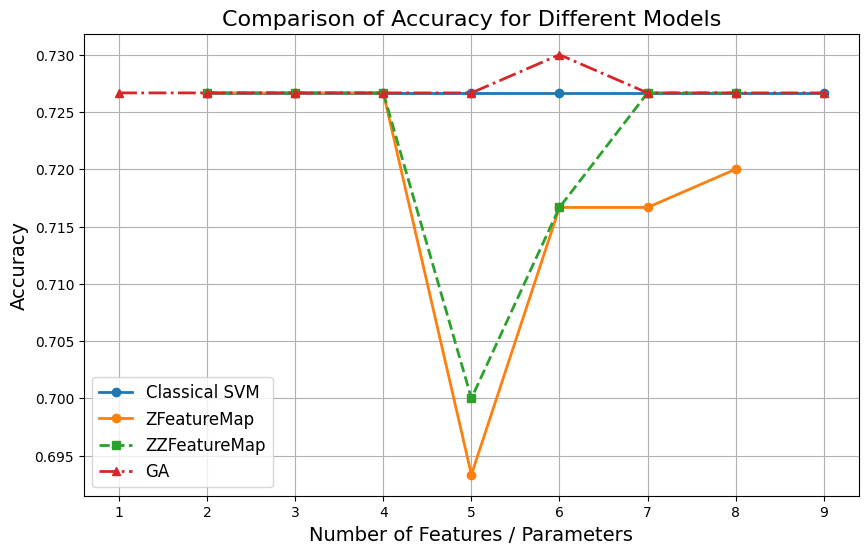

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.plot(features, accuracies, marker='o', linestyle='-', label='Classical SVM', linewidth=2)


plt.plot(zfeatures, zaccuracies, marker='o', linestyle='-', label='ZFeatureMap', linewidth=2)


plt.plot(zzfeatures, zzaccuracies, marker='s', linestyle='--', label='ZZFeatureMap', linewidth=2)

plt.plot(deduplicated_features, deduplicated_accuracies, marker='^', linestyle='-.', label='GA', linewidth=2)


plt.title("Comparison of Accuracy for Different Models", fontsize=16)
plt.xlabel("Number of Features / Parameters", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)


plt.show()
